In [82]:
##### TEST MODIFICATION LOCALE ####

# todo : revoir la manière dont je gère les graphes et les axes : je pense qu'il faudrait que je les construise séparément
# puis que je les mette dans un figure séparée en subplot
# todo : faire une légende des couleurs de pools
# todo : remettre la distance matrix sur une échelle de 1 à 100
# todo : dans show_config, remettre l'ordre de la matrice de distance puis essayer de mettre en évidence les pools (avec la
# légende idem de l'autre)

# faire une première partie sur la combinatoire, en faisant le truc un peu bien.
# todo : corriger la prise en compte du max. Aujourd'hui, c'est le max de chaque pool qui est pris en compte dans le score
# au lieu du max de tout
# todo : idem au point précédent, vérifier si l'écart type est bien pris en compte
# todo : mesurer un temps acceptable dans le parcours brutal, et ajouter un print à la fin du run pour dire combien de 
# combinaisons ont été explorées
# todo : faire une fonctionnalité qui permet de sauvegarder dans un fichier les différents run faits, avec paramètres,
# coordonnées et résultats
# todo : commencer à regarder un algo plus greedy, d'abord un qui échange les villes dès que c'est positif, et l'autre qui 
# échange sur le gain maximum
# todo : traiter le cas où on n'a pas forcément des pools de la même taille
# todo : ! réservé au fonctions de scoring splitables
# précomputer le score des pools (ex : le 1,2,3,4 vaut xxx pour mon problème, et je le recalcule pas systématiquement à
# la voléé)
# todo : ! réservé au fonctions de scoring splitables : faire la descente logarithmique en coupant le problème en deux 
# puis en deux puis en deux...

# Introduction
## Problem statement

This problem has been submitted by one of my colleagues. Besides being both a nice guy and a talented developper, he also is the president of the roller federation. He therefore has to sometimes participate in the construction of french roller hockey tournaments.

That is where he sometimes is faced with quite a challenge: dividing dozens of teams from various cities into smaller groups, which will then compete in round-robin tournaments. The problem is that he must try to be as efficient as possible when it comes to the cost of travel for each team. The cost of a scenario may be something as simple as the sum of total distance traveled by the teams, but it can also get far more complicated when trying to add some fairness to it: 
- trying to minimze the distance run by the team with the greatest one
- adding other criteria to the cost function: adding the standard deviation of total distance for each team to the overall cost
- putting some weight over the "richest" teams by considering the cost of distance being smaller for them...

The simplest case would be minimizing total distance run by all teams, and after analysis: given points on a plane, how do I split them in same size groups so that total distance between points in the same group is minimized? 



![title](img/image.png)
<i><center>Example of 12 cities to split into 4 pools of 3</center></i>


## Why does this problem seem interesting to me?
Besides the immediate reward of being helpful to a colleague, the more I gave thought to this problem, the more I noticed that it presents many nice aspects:
- being kind of "trading salesman"-ish, it looks like it would be an endless playground for optimization
- furthermore, many python functionalities and libraries might get involved: iterators and generators, decorators, graphical tools from matplotlib and seaborn, file writing and reading to get some persistence, calls to Google Maps API to work on real life data... 
- last but not least, when I first got to see some solutions on problem small enough to be *brutally* solved, I noticed that I could have had them simplified (sometimes solved!) just by looking at it. I might in the end get some Machine Learning algorithms working on this subject.

## Disclaimer
I am definitely not a professional developper (yet?), and my sometimes cumbersome logic or alien syntax might make seasoned readers cringe. I definitely am open to any suggestion as to improve the following.

# Imports

In [31]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from itertools import combinations
from itertools import cycle
from copy import deepcopy
from collections import defaultdict
from math import factorial
import geography.geography as geo

# Geography

## What for?
First of all, I will define a class that will hold the distance cost between cities. For the first run of optimization, I will work with cost between two cities being the distance between them. That will enable me to visually check whether my code is possibly giving acurate results or being completely dumb.

I want that class to allow me to 
- create a map of cities from coordinates, or randomly set one up
- assign them names
- compute the distance matrix between every couple of cities
- show a visual representation of the map
- apply and give a visual representation of a configuration
- compute the cost of a configuration

This class will then be extended as to get real data, for example from the Google Maps APIs.

## Class definition

Class definition is all set up in the //geography//geography module.

## Class tests
### 1- Constructor and `show` method

(<matplotlib.axes._subplots.AxesSubplot at 0x22c96a31da0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22c9866f438>)

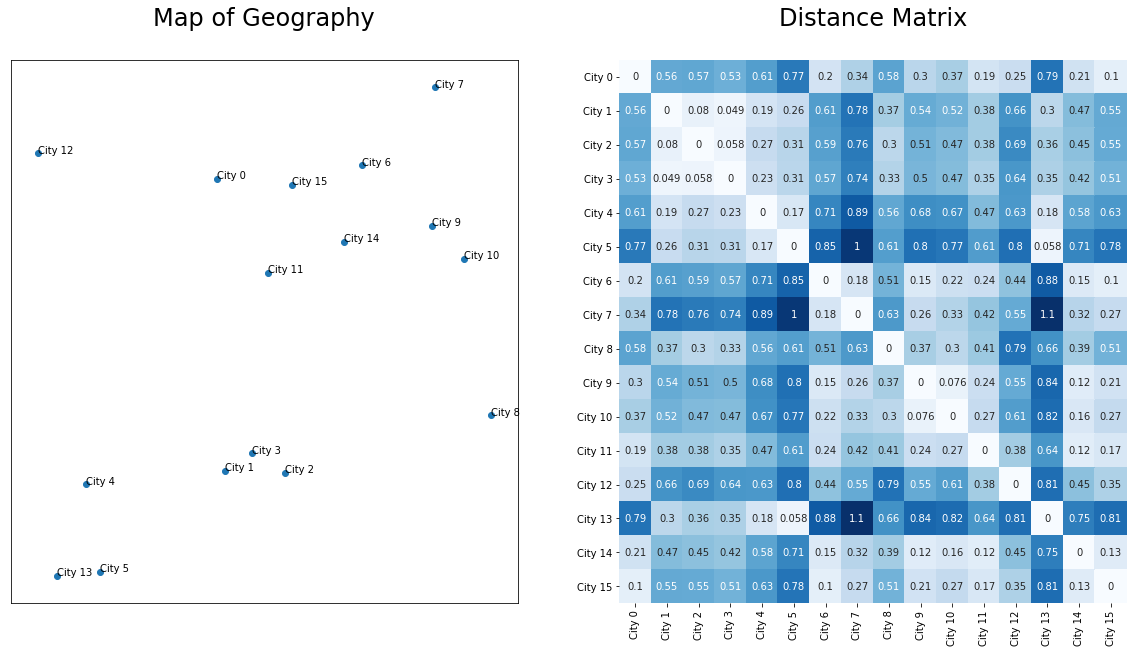

In [33]:
geog = geo.geography(16)
geog.show(show_names=True, annot=True)

### 2- `show_config` method

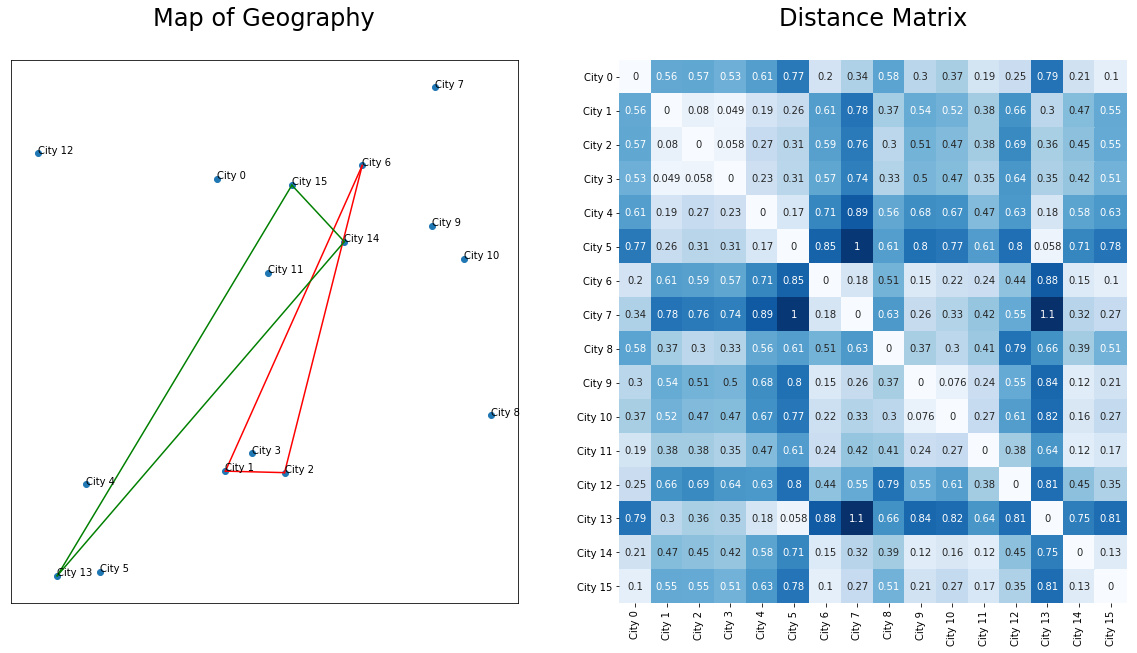

In [34]:
geog.show_config({0 : set([2,6,1]), 1: set([13,14,15])}, show_names=True, annot=True)

# Hic sunt dracones
Below content is just for experimentation.

# Analyse de la combinatoire
## Cas de la factorielle

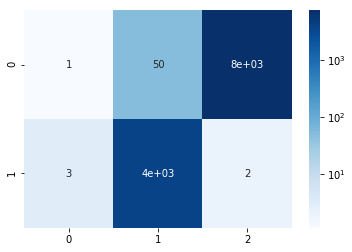

In [4]:
sns.heatmap([[1, 50, 8000], [3, 4000, 2]], 
            annot=True, 
            robust=True, 
            cmap='Blues', 
            cbar_kws={"ticks":[0,1,10,100,1000,10000,100000]},
            norm=LogNorm())

In [5]:
# paramètres du problème
pool_count = 4
pools = {i:set() for i in range(1, pool_count+1)}
cities = {
    0: 'Paris',
    1: 'Montpellier',
    2: 'Marseille',
    3: 'Fontenay aux Roses',
    4: 'Antony',
    5: 'Saint Denis',
    6: 'Sceaux',
    7: 'Chatenay Malabry',
    8: 'Lyon',
    9: 'Bordeaux',
    10: 'Tresses',
    11: 'Pau', 

    
}
city_count = 12


In [6]:
# définition des fonctions de base
def eucl_dist(x1, y1, x2, y2):
    # distance euclidienne entre les points 1 et 2 de coordonnées (x1,y1) et (x2,y2)
    return( ((x2-x1)**2. + (y2-y1)**2.)**0.5 )

def dist_sum(i_dist_matrix, indexes):
    # Ok : retourne la somme des distances depuis la matrice de distance
    # basique, juste la somme des distances, mais optimisée.
    # ne pas réutiliser en l'état, finalement il vaut mieux passer par pandas
    ret=0
    for combi in combinations(indexes, 2):
        c1, c2 = sorted(combi)
        ret += i_dist_matrix[c1][c2]
    return(ret)       


In [7]:
# préparation des cas de test
def create_prob(city_count, pool_count):
    coordinates = np.random.rand(city_count,2)
    dist_matrix = np.array([[eucl_dist(coordinates[i][0], coordinates[i][1], coordinates[j][0], coordinates[j][1]) if i>j else 0. for i in range(city_count)] for j in range(city_count)])
    pools = {i: set(range(i*(city_count//pool_count), (i+1)*(city_count//pool_count))) for i in range(pool_count)}
    return(coordinates, dist_matrix, pools)

def plot_prob(coordinates, cities, plot_names=True):
    plt.figure(figsize=(10,10))
    plt.scatter(coordinates[:,0], coordinates[:,1])
    plt.tick_params(
        axis='both',          
        which='both',      
        bottom=False,      
        top=False, 
        left=False,
        right=False,
        labelbottom=False, 
        labeltop=False,
        labelleft=False,
        labelright=False) 
    if plot_names:
        for i in range(len(coordinates)):
            plt.annotate(cities[i], (coordinates[i, 0], coordinates[i, 1]))

# calcul de la complexité du problème
def combination_count(city_count, pool_count):
    # uniquement quand les pools sont de la même taille
    city_per_pool = city_count // pool_count
    return(factorial(city_count) // factorial(pool_count) // (factorial(city_per_pool)**pool_count))


In [8]:
print(combination_count(16,4)/combination_count(12,4))


170.625


In [9]:
# création de la table des distances sous la forme d'un dataframe
# dont les colonnes sont : 
# city_num
# city_name
# pool
# dist_to_nth : distance to nth other city in pool
# colonnes de calcul du score
def create_dist_df(i_cities, i_pools, i_coordinates):
    #todo: nettoyer, on dirait du vomi...
    _dict_from = dict()
    _width = max([len(i_pools[i]) for i in i_pools])-1
    _dict_from =         {
        'ID':   list(i_cities), 
        'Name': list(i_cities.values())
        }
    for i in range(_width):
        _dict_from['city'+str(i+1)] = 0
        _dict_from['dist'+str(i+1)] = 0.
    ret = pd.DataFrame(_dict_from)

    ret = pd.concat([ret, pd.DataFrame(i_coordinates, columns=['x', 'y'])], axis=1)
    return(ret)

def update_pools_in_df(i_df, i_pools, i_dist_matrix ):
    for _pool, _cities in i_pools.items():
        for _city in _cities:
            i_df.at[_city, 'pool'] = _pool
            i = 1
            for _city2 in sorted(_cities):
                if _city == _city2:
                    continue
                i_df.at[_city, 'city'+str(i)] = _city2
                c1, c2 = sorted((_city, _city2))
                i_df.at[_city, 'dist'+str(i)] = i_dist_matrix[c1][c2]
                i += 1
    i_df['pool'] = i_df['pool'].astype(int)



In [10]:
# problem ploting from the full dataframe
def plot_from_df(_df, cmap=['r','g','b','k','c','y','m']):
    plt.figure(figsize=(3,3))
    for index, row in _df.iterrows():
        plt.scatter(row['x'], row['y'], color=cmap[row['pool']])
        plt.annotate(row['Name'], (row['x'], row['y']))
        i=1
        while 'city'+str(i) in _df:
            _city = row['city'+str(i)]
            _to = _df.iloc[_city][['x','y']]
            plt.plot([row['x'], _to['x']], [row['y'], _to['y']], '-', color=cmap[row['pool']])
            i += 1


In [11]:
# functions for scoring
def row_scoring(_df):
    #computes row total distance
    i=2
    _ds = _df['dist1']
    while 'dist'+str(i) in _df:
        _ds = _ds+ _df['dist'+str(i)]
        i += 1 
    _df['dist_sum'] = _ds   
    
def pool_scoring(_df, mean_coef=1., dist_coef=0., max_coef=0., std_coef=0.):
    # function aggregating to pool and scoring
    _grouped_df = df.groupby('pool')
    ret = pd.DataFrame()
    ret['sum'] = _grouped_df['dist_sum'].sum()
    ret['max'] = _grouped_df['dist_sum'].max()
    ret['mean'] = _grouped_df['dist_sum'].mean()
    ret['std'] = _grouped_df['dist_sum'].std()    
    ret['score'] = ret['mean']*mean_coef + ret['max']*max_coef + ret['sum']*dist_coef + ret['std']*std_coef
    return(ret)

def final_scoring(_df, mean_coef=1., dist_coef=0., max_coef=0., std_coef=0.):
    return(pool_scoring(_df, mean_coef=1., dist_coef=0., max_coef=0., std_coef=0.)['score'].sum())

    ID                Name  city1  city2     dist1     dist2         x  \
0    0               Paris      1      2  0.719591  0.483975  0.906952   
1    1         Montpellier      0      2  0.719591  0.493541  0.517950   
2    2           Marseille      0      1  0.483975  0.493541  0.994240   
3    3  Fontenay aux Roses      4      5  0.714879  0.504493  0.731044   
4    4              Antony      3      5  0.714879  0.988142  0.026933   
5    5         Saint Denis      3      4  0.504493  0.988142  0.959725   
6    6              Sceaux      7      8  0.572923  0.291331  0.647073   
7    7    Chatenay Malabry      6      8  0.572923  0.281743  0.660808   
8    8                Lyon      6      7  0.291331  0.281743  0.647473   
9    9            Bordeaux     10     11  0.302546  0.263374  0.330264   
10  10             Tresses      9     11  0.302546  0.370390  0.392977   
11  11                 Pau      9     10  0.263374  0.370390  0.593172   

           y  pool  dist_sum  
0   0.

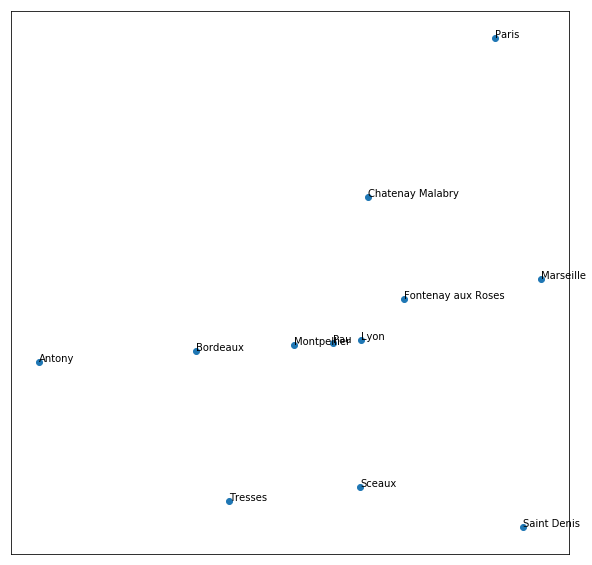

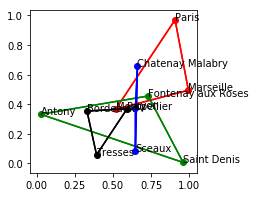

In [15]:
# test de mes fonctionnalités

coordinates, dist_matrix, pools = create_prob(city_count, pool_count)
plot_prob(coordinates, cities, plot_names=True)

df = create_dist_df(cities, pools, coordinates)
update_pools_in_df(df, pools, dist_matrix )
plot_from_df(df)    

row_scoring(df)
print(df)
pool_score = pool_scoring(df, mean_coef=1., dist_coef=0., max_coef=0., std_coef=0.)
print(pool_score)

In [13]:
# je brutalise un peu ; mais en tentant quand même de faire un générateur un peu malin
def pool_generator(city_count, pool_count, current_city=0, current_pool_dict=None, cpt_debug=0):
    #d'abord, je prends l'hypothèse que mes pools sont toutes de la même taille
    # todo : gérer ce cas (pools pas toutes de la même taille)
    # todo : je pense que maintenir la taille de mes pools serait plus malin que de refaire len(current_pool_dict[i]) 
    # à chaque fois...
    if current_pool_dict == None: current_pool_dict = defaultdict(set)
    pool_size = city_count // pool_count
    if current_city >= city_count:
        yield(current_pool_dict)
    for i in range(min(len(current_pool_dict)+1, pool_count)):
        if len(current_pool_dict[i]) >= pool_size:
            continue
        temp_pool_dict = deepcopy(current_pool_dict)
        temp_pool_dict[i].add(current_city)
        yield from pool_generator(city_count, pool_count, current_city=current_city+1, current_pool_dict=temp_pool_dict, cpt_debug=cpt_debug+1)

2.364419575639024
2.4072830681873
2.452606079129665
5.9532278879468565
5.956254016001984
5.961584308650842


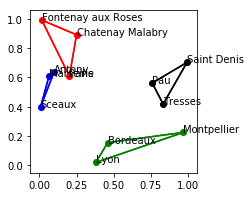

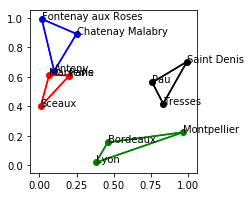

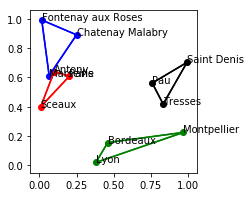

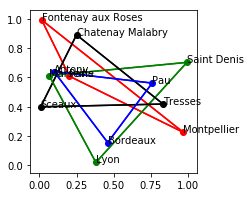

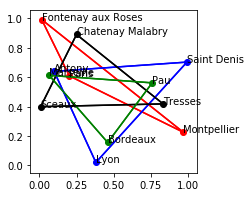

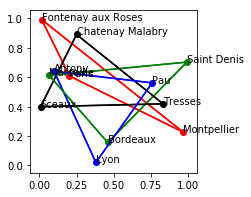

In [14]:
result_list = []

def solve_brutal(cities, pool_count, coordinates):
    pass

def solve(cities, pool_count, coordinates, solver='brutal'):
    if solver == 'brutal':
        return(solve_brutal(cities, pool_count, coordinates))

for pool in pool_generator(12,4):
    df = create_dist_df(cities, pool, coordinates)
    update_pools_in_df(df, pool, dist_matrix )
    #plot_from_df(df)    
    row_scoring(df)
    #pool_score = pool_scoring(df, mean_coef=1., dist_coef=0., max_coef=0., std_coef=0.)
    #print(final_scoring(df, mean_coef=1., dist_coef=0., max_coef=0., std_coef=0.))
    result_list.append( (final_scoring(df, mean_coef=1., dist_coef=0., max_coef=0., std_coef=0.), df.copy()) )

for result in sorted(result_list)[:3]:
    print(result[0])
    plot_from_df(result[1])
    
for result in sorted(result_list)[-3:]:
    pass
    #print(result[0])
    #plot_from_df(result[1])
